# Predictions evaluation

## Importing

In [1]:
import json
from google_drive_downloader import GoogleDriveDownloader as gdd
import shutil, os
from ops import load_opt, load_sar, generate_save_patches, min_max_scaler
import numpy as np
import logging
from PIL import Image
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pickle
import numpy as np
import skimage.morphology
from sklearn.metrics import confusion_matrix

In [2]:
def compute_matrics(thresholds, prob_map, labels, test_mask, area_no_considered):   
    metrics_all = []
    
    for thr in thresholds:
        print(thr)  

        img_reconstructed = np.zeros_like(prob_map).astype(np.int8)
        img_reconstructed[prob_map >= thr] = 1
        
        # Mask to remove areas < 6.25 ha
        mask_areas_pred = np.ones_like(labels)
        area = skimage.morphology.area_opening(img_reconstructed, area_threshold = area_no_considered, connectivity=1)
        area_no_consider = img_reconstructed-area
        mask_areas_pred[area_no_consider==1] = 0
        
        # Mask of edges no considered 
        mask_borders = np.ones_like(img_reconstructed)
        mask_borders[labels==2] = 0
        
        mask_no_consider = mask_areas_pred * mask_borders 
        ref_consider = mask_no_consider * labels
        pred_consider = mask_no_consider*img_reconstructed
        
        ref_final = ref_consider[test_mask==1]
        pre_final = pred_consider[test_mask==1]

        
        # Metrics
        cm = confusion_matrix(ref_final, pre_final)
        #TN = cm[0,0]
        FN = cm[1,0]
        TP = cm[1,1]
        FP = cm[0,1]
        precision_ = TP/(TP+FP)
        recall_ = TP/(TP+FN)
        rec_pre = np.hstack((recall_, precision_))
        metrics_all.append(rec_pre)
    out_metrics = np.asarray(metrics_all)
    return out_metrics

# Function to compute mAP
def compute_mAP(X, Y):
    #X -> Recall
    #Y -> Precision
    dx = np.diff(X)
    X_ = np.array([])
    Y_ = np.array([])
    
    eps = 5e-3
    for i in range(len(dx)):
        if dx[i] > eps:
            x0 = X[i]; x1 = X[i+1]
            y0 = Y[i]; y1 = Y[i+1]
            a = (y1 - y0) / (x1 - x0)
            b = y0 - a * x0
            x = np.arange(x0, x1, eps)
            y = a * x + b                
            X_ = np.concatenate((X_, x))
            Y_ = np.concatenate((Y_, y))
        else:
            X_ = np.concatenate((X_, X[i:i+1]))
            Y_ = np.concatenate((Y_, Y[i:i+1]))
                    
    X_ = np.concatenate((X_, X[-1:]))
    Y_ = np.concatenate((Y_, Y[-1:]))
    
    new_dx = np.diff(X_)
    map_ = 100 * np.inner(Y_[:-1], new_dx)
    
    return map_

In [4]:
#load the params-patches.json options
with open(os.path.join('v1', 'params-patches.json')) as param_file:
    params_patches = json.load(param_file)

#load the params-models.json options
with open(os.path.join('v1', 'params-model.json')) as param_file:
    params_model = json.load(param_file)
    

In [5]:
pred_path = 'pred_2'

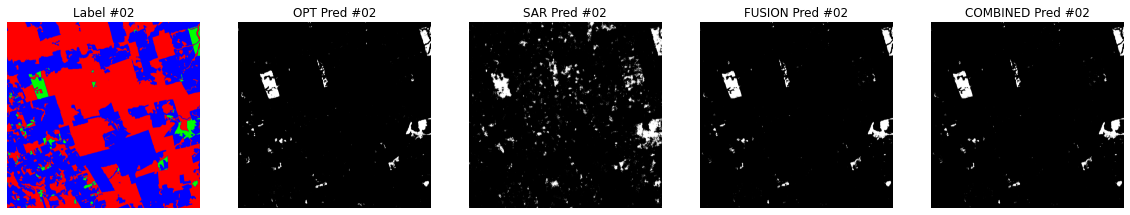

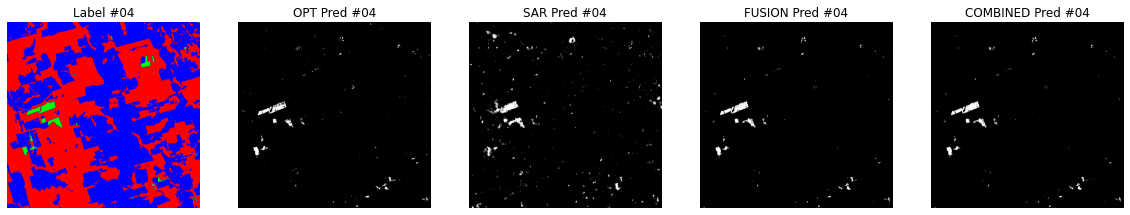

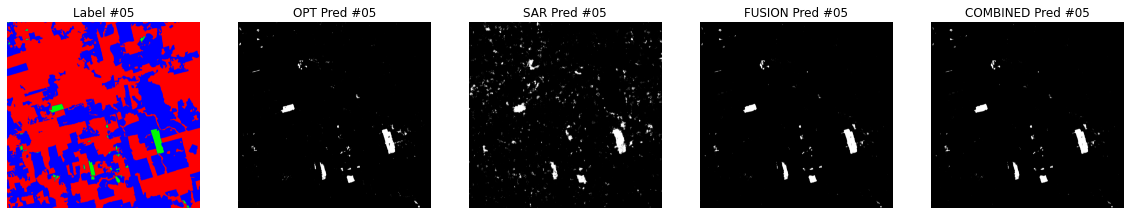

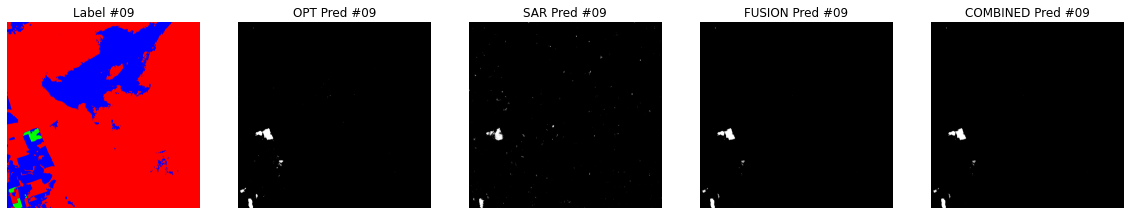

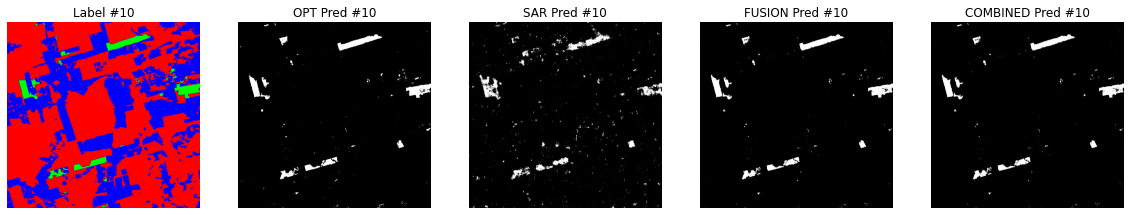

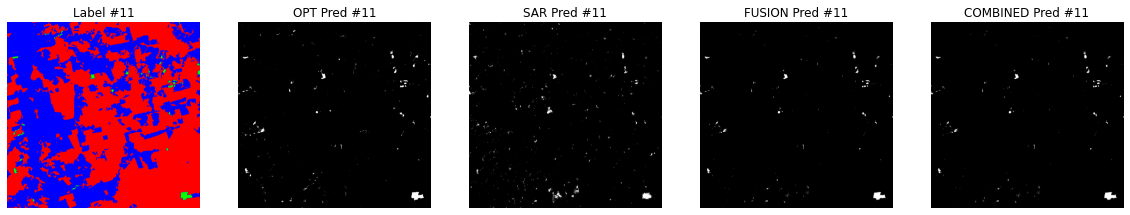

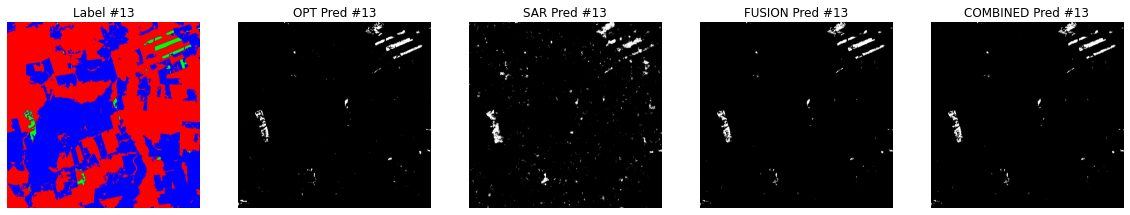

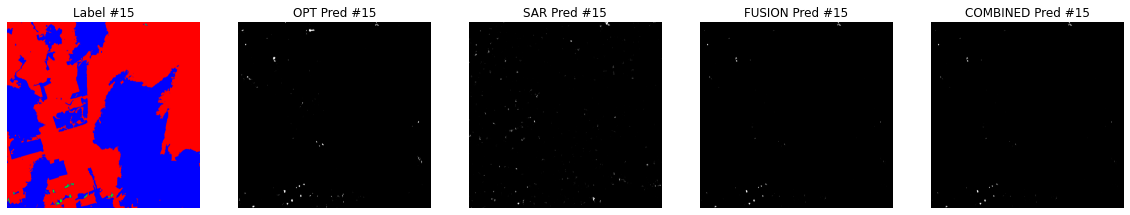

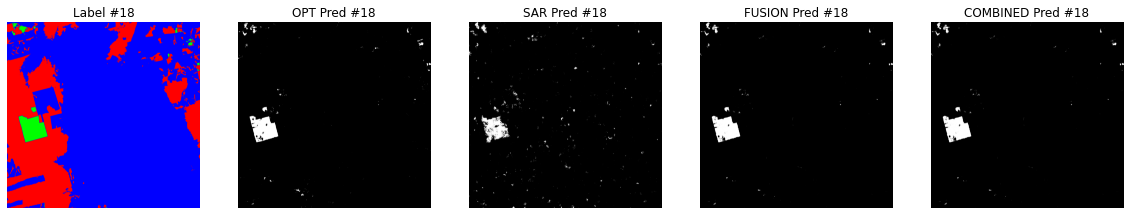

In [12]:
test_tiles = params_patches['test_tiles']
for test_tile in test_tiles:
    label = np.load(os.path.join(params_patches['tiles_path'], params_patches['label_sub'], f'label_{test_tile:02d}.npy')).squeeze()
    shape = label.shape

    opt_pred_tile = np.load(os.path.join(pred_path, f'pred_opt_{test_tile:02d}.npy'))[:,:,1]
    sar_pred_tile = np.load(os.path.join(pred_path, f'pred_sar_{test_tile:02d}.npy'))[:,:,1]
    fusion_pred_tile = np.load(os.path.join(pred_path, f'pred_fusion_{test_tile:02d}.npy'))[:,:,1]
    combined_pred_tile = np.load(os.path.join(pred_path, f'pred_combined_{test_tile:02d}.npy'))[:,:,1]

    fig, ax = plt.subplots(nrows=1, ncols=5, figsize = (20,60))

    categorical = to_categorical(label, params_model['classes'])
    img = Image.fromarray(np.uint8(categorical*255))
    ax[0].axis('off')
    ax[0].set_title(f'Label #{test_tile:02d}')
    ax[0].imshow(img)

    img = Image.fromarray(np.uint8(opt_pred_tile*255))
    ax[1].axis('off')
    ax[1].set_title(f'OPT Pred #{test_tile:02d}')
    ax[1].imshow(img, cmap='gray')

    img = Image.fromarray(np.uint8(sar_pred_tile*255))
    ax[2].axis('off')
    ax[2].set_title(f'SAR Pred #{test_tile:02d}')
    ax[2].imshow(img, cmap='gray')

    img = Image.fromarray(np.uint8(fusion_pred_tile*255))
    ax[3].axis('off')
    ax[3].set_title(f'FUSION Pred #{test_tile:02d}')
    ax[3].imshow(img, cmap='gray')

    Img = Image.fromarray(np.uint8(combined_pred_tile*255))
    ax[4].axis('off')
    ax[4].set_title(f'COMBINED Pred #{test_tile:02d}')
    ax[4].imshow(img, cmap='gray')
    

1.0